In [2]:
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## STEP 1 : Load Data

In [4]:
data_path = "../sga_data/ex1/adult-subset-for-synthetic.csv"
metadata_table = SingleTableMetadata()
original_data = pd.read_csv(data_path)
metadata_table.detect_from_csv(filepath=data_path)

# necessary for later one-hot encoding
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "sex", "native-country", "salary-class"]
numeric_cols = ["age", "capital-gain", "hours-per-week"]


### Split the original data and synthesize new

In [5]:

# Split the data: Matr. No: 2210585027
seed = 2210585027
orig_trainig_data, orig_test_data = train_test_split(original_data, test_size=0.2, random_state=seed)

synthesizer = SingleTablePreset(
    metadata_table,
    name='FAST_ML'
)

# only fit it to the training set
synthesizer.fit(
    data=orig_trainig_data
)

synthetic_data = synthesizer.sample(
    num_rows=30_000,
    batch_size=1_000
)

syn_trainig_data, syn_test_data = train_test_split(synthetic_data, test_size=0.2, random_state=seed)
synthetic_data.head(10)

# Data Sets
# orig_trainig_data ... used to train synthesizer
# orig_test_data    ... kept for syn vs orig classifier validation
# syn_train_data    ... used to train syn vs orig classifier
# syn_test_data     ... kept for syn vs orig classifier validation

c:\Users\Gerald\source\repos\learning\WS2023\DLE\MAINEnv\lib\site-packages\rdt\transformers\categorical.py:329: FutureWarning: The 'FrequencyEncoder' transformer will no longer be supported in future versions of the RDT library. Please use the 'UniformEncoder' transformer instead.
  warnings.warn(
Sampling rows: 100%|██████████| 30000/30000 [00:01<00:00, 16562.93it/s]


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary-class
0,43,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,9927,492,48,United-States,<=50K
1,52,Private,11th,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,38,United-States,>50K
2,50,Private,Some-college,Divorced,Tech-support,Other-relative,White,Female,3388,0,45,United-States,<=50K
3,53,Self-emp-not-inc,HS-grad,Never-married,Other-service,Not-in-family,White,Male,0,134,54,United-States,<=50K
4,53,Private,Some-college,Never-married,Prof-specialty,Husband,Black,Male,0,0,40,United-States,<=50K
5,59,Private,Some-college,Never-married,Exec-managerial,Not-in-family,White,Male,4239,496,40,United-States,<=50K
6,35,Private,Bachelors,Never-married,Craft-repair,Not-in-family,White,Male,667,310,37,United-States,<=50K
7,56,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Not-in-family,White,Female,1263,0,38,United-States,<=50K
8,48,Private,HS-grad,Never-married,Craft-repair,Not-in-family,White,Female,5206,208,52,United-States,<=50K
9,17,Private,Bachelors,Married-AF-spouse,Craft-repair,Own-child,White,Female,7659,51,17,United-States,<=50K


## STEP 2 : Histogramms of ORIG vs SYN Data

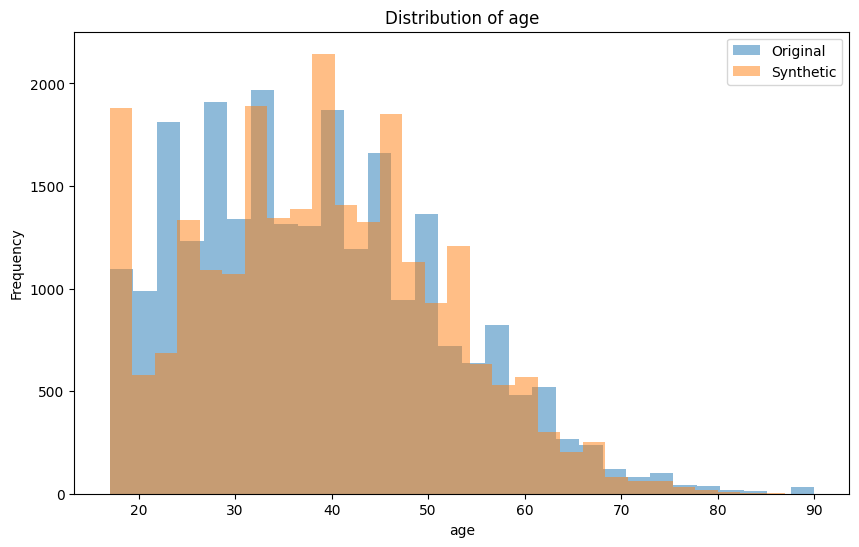

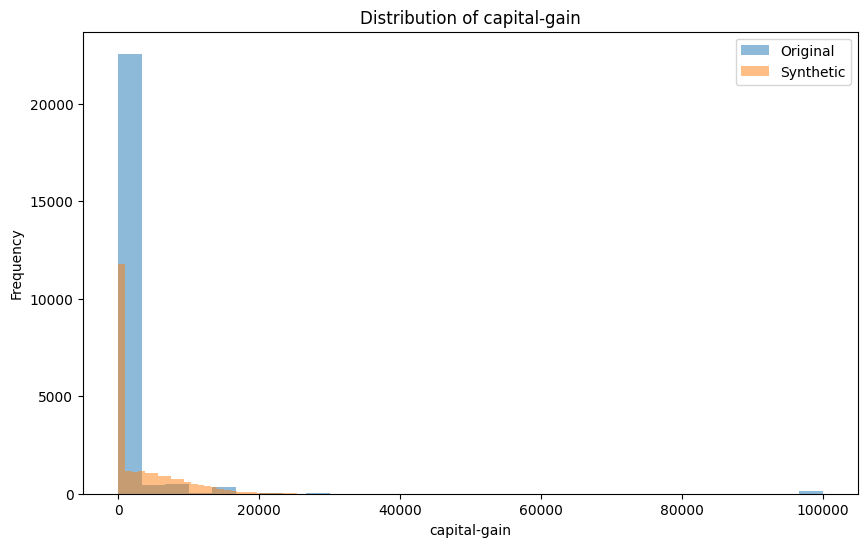

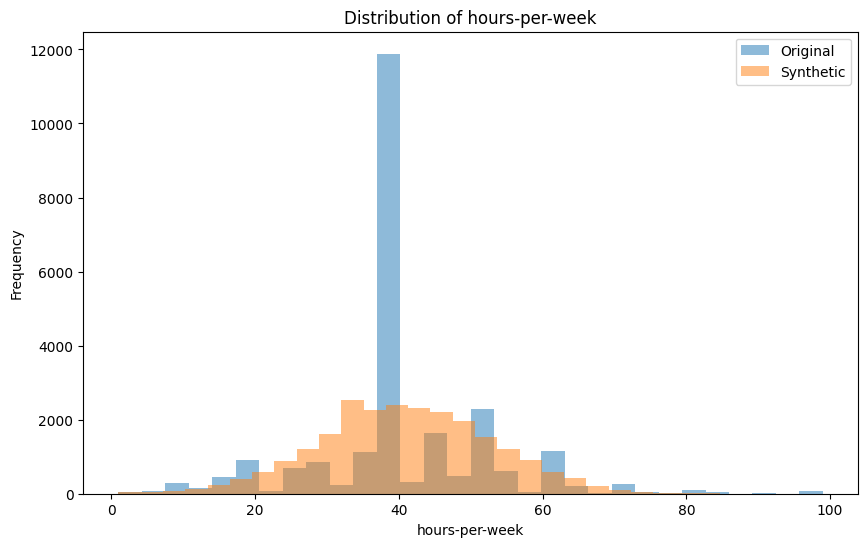

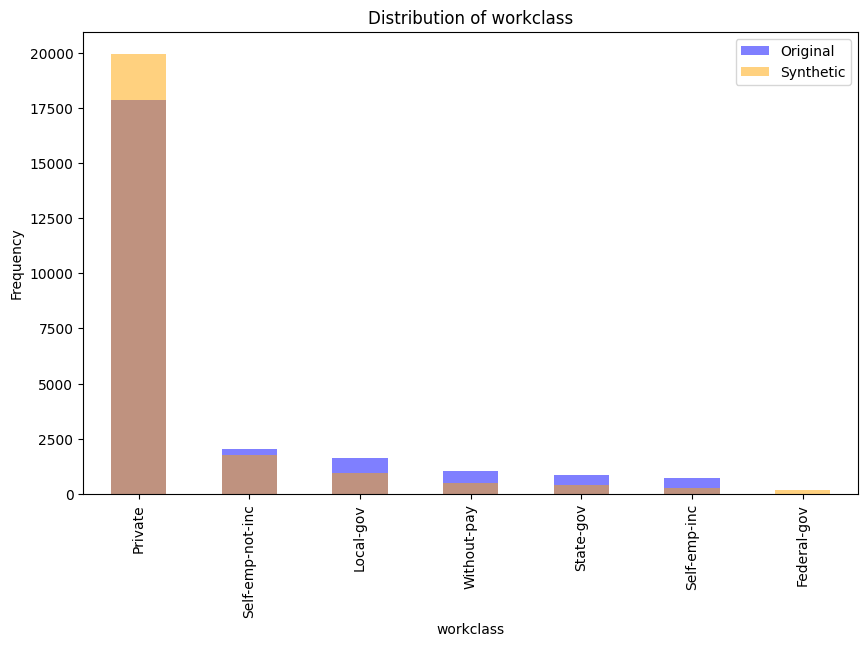

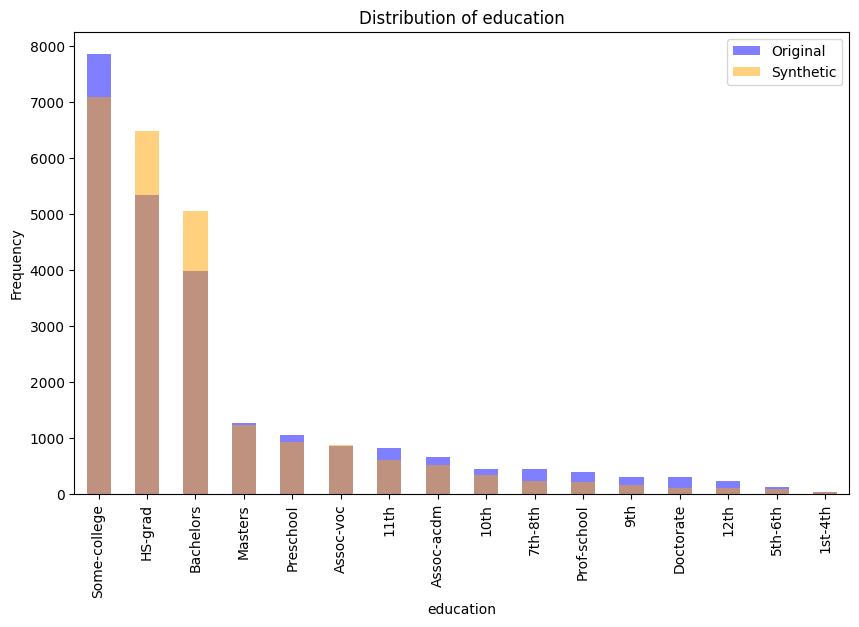

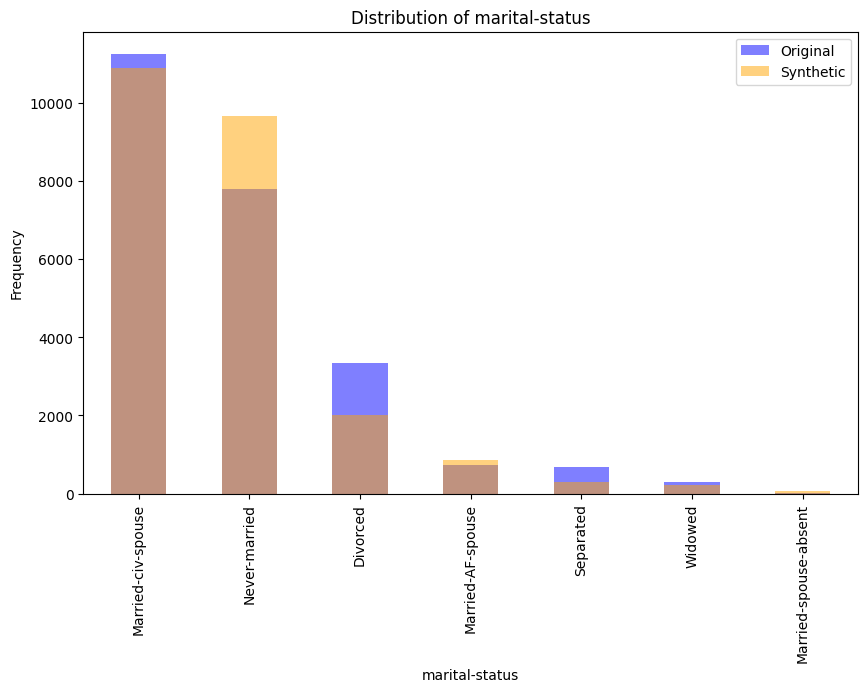

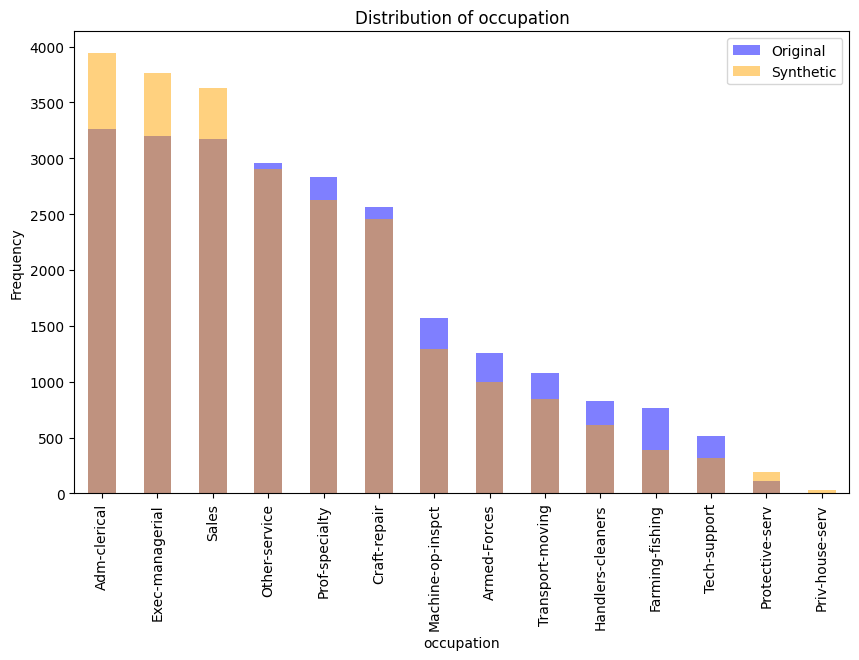

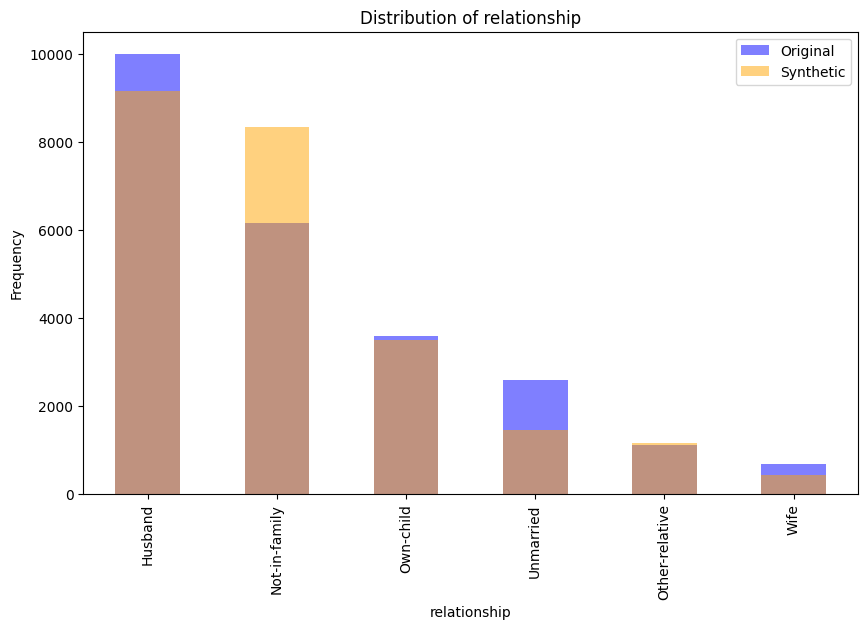

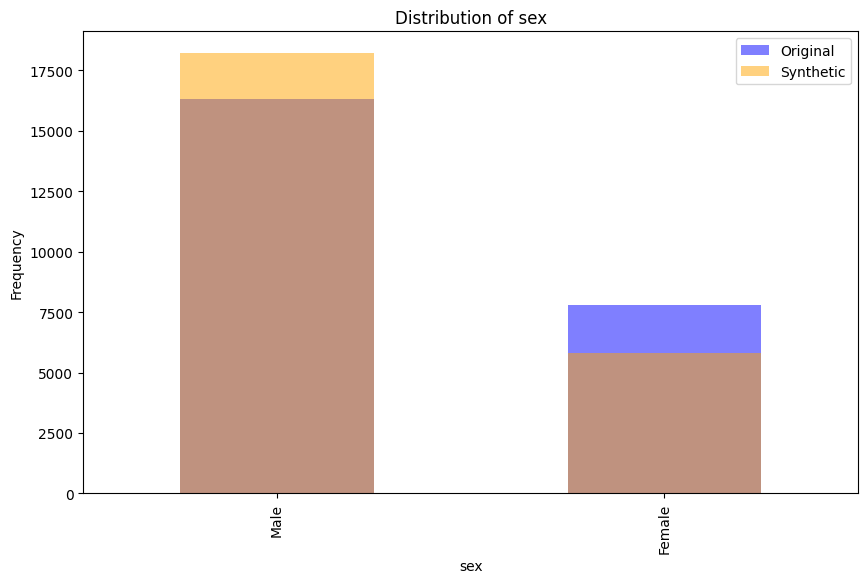

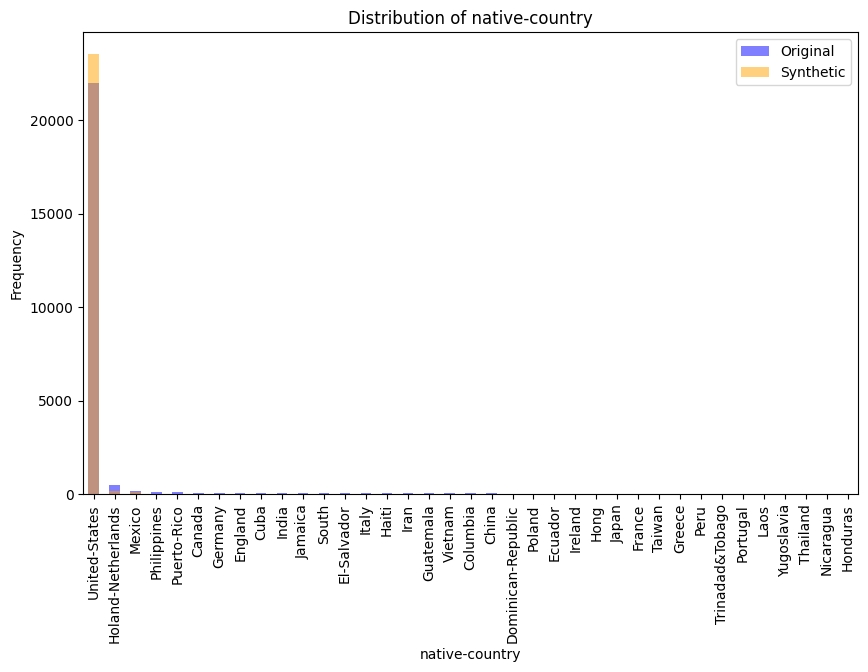

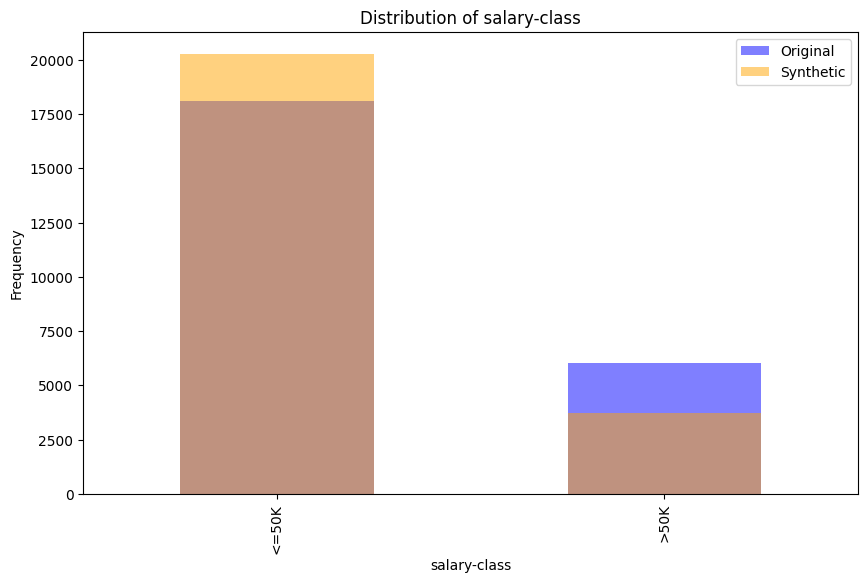

In [6]:

# Plot histograms for numerical columns
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    plt.hist(orig_trainig_data[col], alpha=0.5, label='Original', bins=30)
    plt.hist(syn_trainig_data[col], alpha=0.5, label='Synthetic', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# For categorical columns, you can use bar plots
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    orig_trainig_data[col].value_counts().plot(kind='bar', alpha=0.5, color='blue', label='Original')
    syn_trainig_data[col].value_counts().plot(kind='bar', alpha=0.5, color='orange', label='Synthetic')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()



## STEP 3 : Correlation between SYN and ORIG data

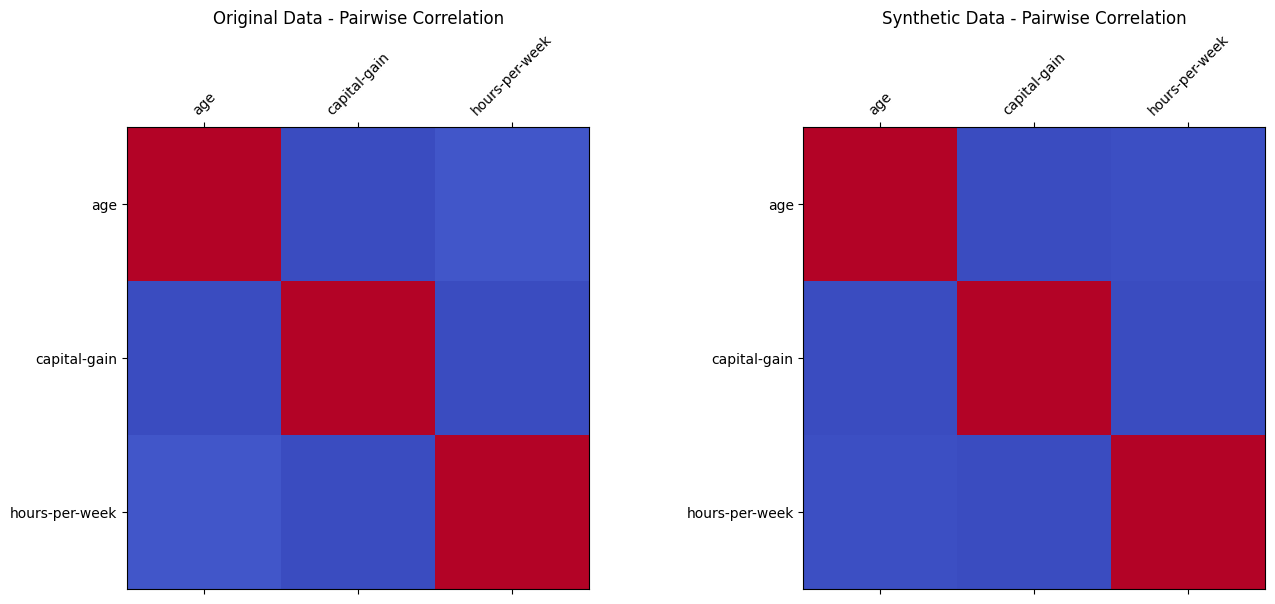

In [7]:
# STEP 3

# Pairwise correlation matrix for original data
orig_corr = orig_trainig_data[numeric_cols].corr()

# Pairwise correlation matrix for synthetic data
syn_corr = syn_trainig_data[numeric_cols].corr()

# Display correlation matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.matshow(orig_corr, cmap='coolwarm')
ax1.set_title('Original Data - Pairwise Correlation')
ax1.set_xticks(range(len(numeric_cols)))
ax1.set_yticks(range(len(numeric_cols)))
ax1.set_xticklabels(numeric_cols, rotation=45)
ax1.set_yticklabels(numeric_cols)

ax2.matshow(syn_corr, cmap='coolwarm')
ax2.set_title('Synthetic Data - Pairwise Correlation')
ax2.set_xticks(range(len(numeric_cols)))
ax2.set_yticks(range(len(numeric_cols)))
ax2.set_xticklabels(numeric_cols, rotation=45)
ax2.set_yticklabels(numeric_cols)

plt.show()



## STEP 4 : Classifier for SYN vs ORIG + Evaluation

In [8]:
### TRAIN DATA ###
syn_training_labels = pd.Series([1] * len(syn_trainig_data))
orig_training_labels = pd.Series([0] * len(orig_trainig_data))
X_train = pd.concat([syn_trainig_data, orig_trainig_data], axis=0)
y_train = pd.concat([syn_training_labels, orig_training_labels], axis=0)

### TEST DATA ###
syn_test_labels = pd.Series([1] * len(syn_test_data))
orig_test_labels = pd.Series([0] * len(orig_test_data))
X_test = pd.concat([syn_test_data, orig_test_data], axis=0)
y_test = pd.concat([syn_test_labels, orig_test_labels], axis=0)

# define pipeline to allow easy one-hot encoding for categorical features
# transformer for one-hot encoding and scaler for numerical features
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

classifier = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=seed))])

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.741876506274412
Confusion Matrix:
[[4567 1466]
 [1640 4360]]


c:\Users\Gerald\source\repos\learning\WS2023\DLE\MAINEnv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
